# Bayesian SIR Model with Change Points

In [1]:
import numpy as np
from scipy.stats import binom, gamma, beta, expon, poisson, uniform, bernoulli
from joblib import Parallel, delayed
from scipy.special import gamma as gammaFunc
import random

import pandas as pd

import matplotlib.pyplot as plt

import tqdm

import pickle 

import itertools

## Data Simulation

In [2]:
def sim_dataset(chg_pt, scenarios, T, S0, I0, R0, n_datasets):

    N = S0 + I0 + R0
    n_sc = scenarios.shape[0]

    # create array of transmission and removal rate parameters at each time step
    beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T)] for i in range(n_sc)])
    gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T)] for i in range(n_sc)])


    Delta_I = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    Delta_R = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    S       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    I       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)
    R       = np.zeros(shape=(n_datasets, n_sc, T), dtype=np.int32)

    Delta_I[:,:,0] = binom.rvs(S0, 1-np.exp(-beta[:,0]*I0/N), size=(n_datasets, n_sc))
    Delta_R[:,:,0] = binom.rvs(I0, gamma[:,0], size=(n_datasets, n_sc))
    S[:,:,0]       = S0 - Delta_I[:,:,0]
    I[:,:,0]       = I0 + Delta_I[:,:,0] - Delta_R[:,:,0]
    R[:,:,0]       = R0 + Delta_R[:,:,0]

    for t in range(1, T):
        Delta_I[:,:,t] = binom.rvs(S[:,:,t-1], 1-np.exp(-beta[:,t]*I[:,:,t-1]/N))
        Delta_R[:,:,t] = binom.rvs(I[:,:,t-1], gamma[:,t])
        S[:,:,t]       = S[:,:,t-1] - Delta_I[:,:,t]
        I[:,:,t]       = I[:,:,t-1] + Delta_I[:,:,t] - Delta_R[:,:,t]
        R[:,:,t]       = R[:,:,t-1] + Delta_R[:,:,t]

    return Delta_I, Delta_R, S, I, R

In [3]:
def plot_SRI(S, I, R, sc=0, d=None, start_cond=(999_950, 50, 0), tot=1_000_000, time=100):

    if d is None:
        S = np.expand_dims(np.mean(S, axis=0), 0)
        I = np.expand_dims(np.mean(I, axis=0), 0)
        R = np.expand_dims(np.mean(R, axis=0), 0)
        d = 0

    S = np.concatenate([[start_cond[0]], S[d,sc]])
    I = np.concatenate([[start_cond[1]], I[d,sc]])
    R = np.concatenate([[start_cond[2]], R[d,sc]])

    # plot
    fig, ax = plt.subplots()

    y = np.vstack([S, I, R])
    ax.stackplot(np.arange(time+1), y/tot, labels=["S","I","R"], alpha=0.8)

    ax.set_xlabel("Day")
    ax.set_ylabel("Proportion")
    ax.set_xticks(np.concatenate([[0], np.arange(25, time+1, 25)]))
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend(loc="upper right")

    plt.show()

### Example

In [4]:
T_max = 100
N = 1_000_000

chg_pt = np.array([26, 51, 76])

sc_1 = [(0.3, 0.05), (0.4, 0.15), (0.25, 0.2),  (0.2,  0.25)]
sc_2 = [(0.4, 0.1),  (0.4, 0.25), (0.25, 0.25), (0.25, 0.4) ]
sc_3 = [(0.5, 0.1),  (0.3, 0.3),  (0.4,  0.2),  (0.2,  0.4) ]
scenarios = np.array([sc_1, sc_2, sc_3])

S0 = N-50
I0 = 50
R0 = 0

n_datasets = 100

Scenario 1:


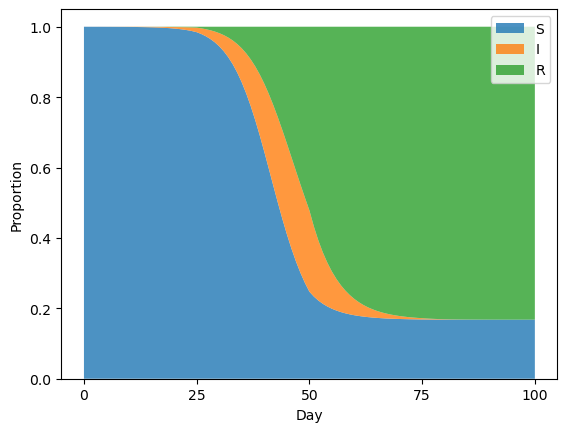

Scenario 2:


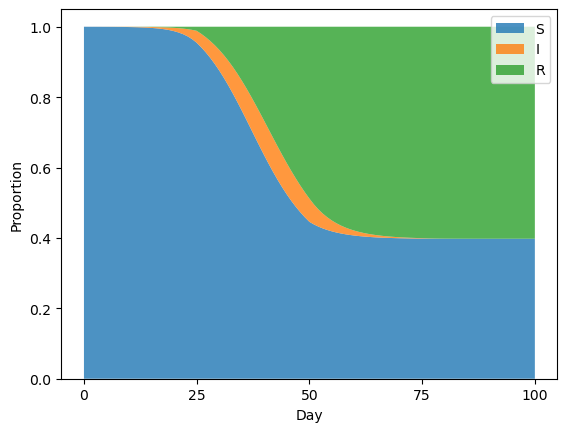

Scenario 3:


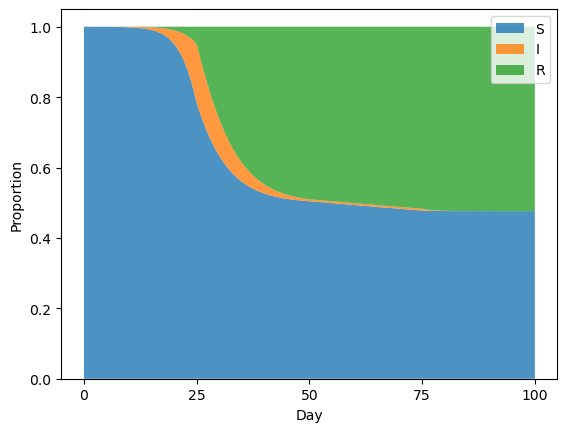

In [5]:
Delta_I, Delta_R, S, I, R =  sim_dataset(chg_pt, scenarios, T_max, S0, I0, R0, n_datasets)
for i in range(len(scenarios)):
    print(f"Scenario {i+1}:")
    plot_SRI(S, I, R, sc=i)

In [6]:
S_obs = np.concatenate(([S0],S[0,0]))
I_obs = np.concatenate(([I0],I[0,0]))
R_obs = np.concatenate(([R0],R[0,0]))
PI_obs = I_obs/N
N_infect_obs = np.concatenate(([I0],Delta_I[0,0]))
N_recovery_obs = np.concatenate(([R0],Delta_R[0,0]))

data = pd.DataFrame({
        'susceptible': S_obs,
        'infects': I_obs,
        'recovered': R_obs,
        'PI': PI_obs,
        'deltaI': N_infect_obs,
        'deltaR': N_recovery_obs
    })

data

,susceptible,infects,recovered,PI,deltaI,deltaR
0,999950,50,0,0.000050,50,0
1,999933,61,6,0.000061,17,6
2,999916,75,9,0.000075,17,3
3,999892,97,11,0.000097,24,2
4,999870,116,14,0.000116,22,3
...,...,...,...,...,...,...
96,174223,23,825754,0.000023,0,4
97,174222,19,825759,0.000019,1,5
98,174222,16,825762,0.000016,0,3
99,174222,9,825769,0.000009,0,7


## Gibbs Sampling

In [7]:
def calculate_contact_hat_parallel(pp_lambda_t):
    pp, lambda_t = pp_lambda_t
    return np.sum(poisson.ppf(pp, lambda_t))

In [8]:
def propose_delta(Delta_hat, K_hat, T_max=100, verbose=False):

    ########## change type
    ## add–delete–swap - proposal step
    # -1 delete
    # 0 swap
    # +1 add
    if K_hat==1:
        change_type = 1
        
    elif K_hat==T_max:
        change_type = -1

    else:
        change_type = np.random.choice([-1, 0, 1])
            
    Delta_hat_candidate = Delta_hat.copy()
    
    ########## proposal phase
    if change_type != 0:
        if change_type == 1:
            possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
        if change_type == -1:
            possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
            
        index_to_change = np.random.choice(possible_change_indices)
            
        Delta_hat_candidate[index_to_change] = 1-Delta_hat_candidate[index_to_change]
            
    else:
        possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
        index_to_change = np.random.choice(possible_change_indices)

        Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]

    Stage_hat_candidate = np.cumsum(Delta_hat_candidate, dtype=int)-1
    K_hat_candidate = np.sum(Delta_hat_candidate, dtype=int)
    
    if verbose:
        print("Original:",  np.where(Delta_hat==1)[0])
        print("Candidate:", np.where(Delta_hat_candidate==1)[0])
        print("---------------------------")

    return Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate


# sampling based on paper
def sample_delta_1(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat, p=0.01, T_max=100, verbose=False):
    
    # propose new delta
    Delta_hat_candidate, Stage_hat_candidate, K_hat_candidate = propose_delta(Delta_hat, K_hat, T_max, verbose)


    ########## Metropolis-Hastings Phase
    
    # Prior log-ratio: pi(d*)/pi(d(g))
    log_pi = (K_hat_candidate-K_hat)*np.log(p/(1-p))
        
    # Likelihood log-ratio: pi(beta(g), gamma(g)|d*)/pi(beta(g), gamma(g)|d(g))
    log1_candidate = 0
    log2_candidate = 0
        
    for k in range(K_hat_candidate):
        ind_k = np.where(Stage_hat_candidate == k)[0]
        log1_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
        log2_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
        
    log1_original = 0
    log2_original = 0
                                     
    for k in range(K_hat):
        ind_k = np.where(Stage_hat == k)[0]
        log1_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
        log2_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
        
    log_L = (log1_candidate+log2_candidate) - (log1_original+log2_original)     
    
    # Jump probability log-ratio: J(d(g)|d*)/J(d*|d(g))
    JJ = 0
    if K_hat == K_hat_candidate:
        JJ = 1 
    elif ([K_hat_candidate, K_hat] == [1, 2] or [K_hat_candidate, K_hat] == [T_max, T_max-1]):
        JJ = 3/(T_max-1)
    elif ([K_hat_candidate, K_hat] == [2, 1] or [K_hat_candidate, K_hat] == [T_max-1, T_max]):
        JJ = (T_max-1)/3
    elif (K_hat_candidate-K_hat) == -1 and K_hat_candidate != 1 and K_hat_candidate != (T_max-1):
        JJ = (K_hat-1)/(T_max - K_hat_candidate)
    elif K_hat_candidate - K_hat == 1 and K_hat_candidate != 2 and K_hat_candidate != T_max:
        JJ = (T_max-K_hat)/(K_hat_candidate-1)
    log_JJ = np.log(JJ)

    
    # Metropolis-Hastings Ratio
    log_mMH = log_L+log_pi+log_JJ
    ratio = np.exp(min(0, log_mMH))

    if verbose:
        print("pi:", log_pi, np.exp(log_pi))
        print("likelihood:", log_L, np.exp(log_L))
        print("JJ:", log_JJ, JJ)
        print("m_MH:", log_mMH, np.exp(log_mMH))
    
    cxx = np.random.binomial(1, ratio) 
    if cxx == 1:
        Delta_hat = Delta_hat_candidate
        Stage_hat = Stage_hat_candidate
        K_hat     = K_hat_candidate
        
    return Delta_hat, Stage_hat, K_hat

In [9]:
# sampling based on code
def sample_delta_2(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat, 
                   b_shape=0.1, b_rate=0.1, gamma_b_shape=9.513507698668732,
                   r_shape=0.1, r_rate=0.1, gamma_r_shape=9.513507698668732,
                   p_a=1e-8, p_b=1.99999999, T_max=100, verbose=False):
    
    ########## change type
    ## add–delete–swap - proposal step
    # -1 delete
    # 0 swap
    # +1 add
            
    if K_hat==1:
        change_type = 1
    
    elif K_hat==T_max:
        change_type = -1
    else:
        change_type = np.random.choice([-1, 0, 1])
        
    Delta_hat_candidate = Delta_hat.copy()
    
    if change_type != 0:
        
        if change_type == 1:
            possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
        elif change_type == -1:
            possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
        index_to_change = np.random.choice(possible_change_indices)

        Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
        Stage_hat_candidate = np.cumsum(Delta_hat_candidate, dtype=int)-1

        if change_type == 1:
            possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 1)[0]+1
            phase_original  = np.array([Stage_hat[index_to_change]])
            phase_candidate = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
        elif change_type == -1:
            possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 0)[0]+1
            phase_original  = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
            phase_candidate = np.array([Stage_hat_candidate[index_to_change]])
    
        logp_original = 0
        logp_candidate = 0
        for i in phase_original:
            L_i_original = np.where(Stage_hat == i)[0]
            logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                           - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                           - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
            logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                           - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                           - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
            logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))
        for i in phase_candidate:
            L_i_candidate = np.where(Stage_hat_candidate == i)[0]
            logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                            - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                            - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
            logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                            - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                            - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
            logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))

        logp_candidate += np.log(p_a / p_b) + np.log((3 - 2 * (K_hat == 1)) \
                        * len(possible_change_indices) / (3 - 2 * ((K_hat + 1) == T_max)) / len(possible_change_indices_candidate))
        
        ratio = np.exp(min([0, logp_candidate - logp_original]))

    elif change_type == 0:
        
        possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
        index_to_change = np.random.choice(possible_change_indices, 1)
        Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]
        Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
        possible_change_indices_candidate = np.where(np.abs(Delta_hat_candidate[1:-1] - Delta_hat_candidate[2:]) == 1)[0]+1
    
        phase = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])

        logp_original = 0
        logp_candidate = 0
    
        for i in phase:
            L_i_original = np.where(Stage_hat == i)[0]
            logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                           - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                           - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
            logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                           - np.log(gamma_b_shape) + r_shape * np.log(r_rate) \
                           - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
            logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))

            L_i_candidate = np.where(Stage_hat_candidate == i)[0]
            logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                            - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                            - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
            logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                            - np.log(gamma_b_shape) + r_shape * np.log(r_rate) \
                            - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
            logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))

        ratio = np.exp(min([0, logp_candidate - logp_original + np.log(len(possible_change_indices) / len(possible_change_indices_candidate))]))

    cxx = np.random.binomial(1, ratio)      
    if cxx == 1:
        Delta_hat = Delta_hat_candidate
        Stage_hat = Stage_hat_candidate
        K_hat     = np.sum(Delta_hat_candidate, dtype=int)

    return Delta_hat, Stage_hat, K_hat

In [10]:
def gibbs_sampling(data, samples=1000, T_max=100, burnin=5000, thinning=10, sample_type='code', verbose=False):
    
    ############# data
    # Data is expected to be a dataframe with 101 rows (100 steps + initial one)
    # OBS: the initial row should display the starting values 
    #      for Susceptible (S), Infected (I), and Recovered (R), with zero values in the 
    #      columns representing changes (deltas) over time.
    
    I_obs = data["infects"].values
    S_obs = data["susceptible"].values
    PI_obs = data["PI"].values
    N_infect_obs = data["deltaI"].values[1:]
    N_recovery_obs = data["deltaR"].values[1:]
    

    #######################
    ##  HYPERPARAMETERS  ##
    #######################
    
    p_a = 1/T_max**4
    p_b = 2 - p_a
    p = 0.01
    
    b_shape = 0.1
    b_rate = 0.1
    r_shape = 0.1
    r_rate = 0.1
    
    gamma_b_shape = gammaFunc(b_shape)
    gamma_r_shape = gammaFunc(r_shape)
    

    ######################
    ##  INITIALIZATION  ##
    ######################
    
    ##### delta
    Delta_hat = np.zeros(shape=T_max, dtype=int)
    Delta_hat[0] = 1
    Stage_hat = np.cumsum(Delta_hat, dtype=int)-1
    K_hat     = np.sum(Delta_hat, dtype=int)

    ##### b and r
    b_hat    = gamma.rvs(a=b_shape, scale=1/b_rate, size=K_hat)
    r_hat    = gamma.rvs(a=r_shape, scale=1/r_rate, size=K_hat)
    
    ##### beta and gamma
    beta_hat    = expon.rvs(scale=1/b_hat[Stage_hat[0]], size=T_max)
    gamma_hat   = beta.rvs(a=r_hat[Stage_hat[0]], b=1, size=T_max)
    lambda_t    = beta_hat*PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    
    beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
    gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
    lambda_t    = beta_hat * PI_obs[:-1]
    p_upper     = 1 - poisson.cdf(0, lambda_t)
    pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
    contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    
    print("Initialization Complete\n")
    if verbose:
        print("Delta_hat:",Delta_hat)
        print("b_hat:",b_hat)
        print("r_hat:",r_hat)
        print("beta_hat:",beta_hat)
        print("gamma_hat:",gamma_hat)
        print("----------------------------------------------------")
        print("----------------------------------------------------")
    

    ################
    ##  SAMPLING  ##
    ################
    
    Delta_all = []
    Stage_all = []
    b_all     = []
    r_all     = []
    beta_all  = []
    gamma_all = []
    
    for step in tqdm.tqdm(range(burnin+thinning*samples)):
        
        ##### delta sampling

        if sample_type=='paper':
            Delta_hat, Stage_hat, K_hat = sample_delta_1(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat, p, T_max)
        elif sample_type=='code':
            Delta_hat, Stage_hat, K_hat = sample_delta_2(Delta_hat, Stage_hat, K_hat, beta_hat, gamma_hat, 
                                                         b_shape, b_rate, gamma_b_shape, r_shape, r_rate, gamma_r_shape,
                                                         p_a, p_b, T_max)
        
        ##### b and r sampling
            
        K_hat = np.sum(Delta_hat)
        
        b_hat = np.zeros(K_hat)
        r_hat = np.zeros(K_hat)
        for i in range(K_hat):
            L_i = np.where(Stage_hat == i)[0]
            b_hat[i] = gamma.rvs(size=1, a=(b_shape + len(L_i)), scale=1/(b_rate + np.sum(beta_hat[L_i])))
            r_hat[i] = gamma.rvs(size=1, a=(r_shape + len(L_i)), scale=1/(r_rate + np.sum(-np.log(gamma_hat[L_i]))))
    
        
        ##### beta and gamma sampling

        beta_hat    = gamma.rvs(a=contact_hat + 1, scale=1/(b_hat[Stage_hat] + PI_obs[:-1]*S_obs[:-1]))
        gamma_hat   = beta.rvs(a=N_recovery_obs + r_hat[Stage_hat], b=1 + I_obs[:-1] - N_recovery_obs)
        lambda_t    = beta_hat * PI_obs[:-1]
        p_upper     = 1 - poisson.cdf(0, lambda_t)
        pp          = [uniform.rvs(size=N_infect_obs[t]) * p_upper[t] + (1 - p_upper[t]) for t in range(T_max)]
        contact_hat = np.array(Parallel(n_jobs=-1)(delayed(calculate_contact_hat_parallel)((pp[t], lambda_t[t],)) for t in range(T_max)))
    

        if verbose:
            if step % 100 == 0 and step != 0:
                print("\nStep:",step)
                print("Delta_hat:",Delta_hat)
                print("b_hat:",b_hat)
                print("r_hat:",r_hat)
                print("beta_hat:",beta_hat)
                print("gamma_hat:",gamma_hat)
                print("----------------------------------------------------")
            
        Delta_all.append(Delta_hat)
        Stage_all.append(Stage_hat)
        b_all.append(b_hat)
        r_all.append(r_hat)
        beta_all.append(beta_hat)
        gamma_all.append(gamma_hat)
  
    # Creazione del DataFrame
    MCMC_chain = {
        'Delta': Delta_all[burnin::thinning],
        'Stage': Stage_all[burnin::thinning],
        'b': b_all[burnin::thinning],
        'r': r_all[burnin::thinning],
        'beta': beta_all[burnin::thinning],
        'gamma': gamma_all[burnin::thinning]
            }
    
    return MCMC_chain

In [11]:
run_chain   = True
sample_type = 'code'
n_samples   = 1000

if run_chain:
    MCMC_chain = gibbs_sampling(data, samples=n_samples, burnin=10, thinning=1, sample_type=sample_type)
    with open(f'Data/Chain_{sample_type}_{n_samples}.pkl', 'wb') as f:
        pickle.dump(MCMC_chain, f)
else:
    with open(f'Data/Chain_{sample_type}_{n_samples}.pkl', 'rb') as f:
        MCMC_chain = pickle.load(f)

Initialization Complete



100%|██████████| 1010/1010 [10:05<00:00,  1.67it/s]


### Estimators

In [12]:
def compute_loss(delta, Q_tt):
    stage = np.cumsum(delta, dtype=int)-1
    Q_candidate = (stage[:, np.newaxis] == stage)
    return np.sum(np.abs(Q_candidate - Q_tt))


def get_estimators(chain, T_max=100, samples=1000):

    ##### Delta

    # get Bayes estimator
    stage = np.array(MCMC_chain["Stage"])
    masks = (stage[:, :, np.newaxis] == stage[:, np.newaxis, :])
    Q_ttprime = np.sum(masks, axis=0)/samples

    Delta_final = np.zeros(shape=T_max, dtype=int)
    Delta_final[0] = 1
    current_loss = compute_loss(Delta_final, Q_ttprime)

    check_add_drop = True
    check_swap = True
    while(check_add_drop==True or check_swap==True):
        # check add or drop
        candidates_loss = np.zeros(shape=(T_max))
        for i in range(1, T_max):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[i] = 1-Delta_candidate[i]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss[1:])+1
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_final[index_min] = 1-Delta_final[index_min]
            check_add_drop = True
        else:
            check_add_drop = False

        possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
        candidates_loss = np.zeros(shape=(len(possible_change_indices)))
        for i, idx in enumerate(possible_change_indices):
            Delta_candidate = Delta_final.copy()
            Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
            candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
        index_min = np.argmin(candidates_loss)
        if candidates_loss[index_min] < current_loss:
            current_loss = candidates_loss[index_min]
            Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
            check_swap = True
        else:
            check_swap = False

        # check swap
        if np.sum(Delta_final) in np.arange(1,T_max-1):
            possible_change_indices = np.where(np.abs(Delta_final[1:-1] - Delta_final[2:]) == 1)[0]+1
            candidates_loss = np.zeros(shape=(len(possible_change_indices)))
            for i, idx in enumerate(possible_change_indices):
                Delta_candidate = Delta_final.copy()
                Delta_candidate[idx+np.array([0,1])] = Delta_candidate[idx+np.array([1,0])]
                candidates_loss[i] = compute_loss(Delta_candidate, Q_ttprime)
            index_min = np.argmin(candidates_loss)
            if candidates_loss[index_min] < current_loss:
                current_loss = candidates_loss[index_min]
                Delta_candidate[possible_change_indices[index_min]+np.array([0,1])] = Delta_candidate[possible_change_indices[index_min]+np.array([1,0])]
                check_swap = True
            else:
                check_swap = False


    ##### beta and gamma
                
    b = np.array([[MCMC_chain["b"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    r = np.array([[MCMC_chain["r"][s][stage[s][t]] for t in range(T_max)] for s in range(samples)])
    beta_final  = np.sum(1/b, axis=0)/samples
    gamma_final = np.sum(r/(1+r), axis=0)/samples


    return Delta_final, beta_final, gamma_final
        

In [29]:
# legacy code
'''
def get_HPD(delta, probs, alpha):
    idxs = np.where(delta[1:]==1)[0]+1
    HPD = np.zeros(shape=(len(idxs),2))
    for n, i in enumerate(idxs):
        P = probs[i]
        i_left, i_right = i, i
        while P < 1-alpha:
            p_left  = probs[i_left-1]
            p_right = probs[i_right+1]
            if p_left >= p_right:
                P += p_left
                i_left -= 1
            else:
                P += p_right
                i_right += 1
        HPD[n,0] = i_left
        HPD[n,1] = i_right
    return HPD

def compute_probs(chain, delta_est, alpha):
    prob_delta = np.mean(np.array(chain["Delta"]), axis=0)
    HPD = get_HPD(delta_est, prob_delta, alpha)

    return prob_delta, HPD 
    '''

In [44]:
def get_HPD(delta, probs, alpha):
    idxs = np.where(delta[1:]==1)[0]+1
    HPD = np.zeros(shape=(len(idxs),2))
    for n, i in enumerate(idxs):
        l = 0 # length of the HPD interval candidate
        P = 0 # probability of the HPD interval candidate
        while True:
            i_left = i-l
            p = np.array([np.sum(probs[i_left+k:i_left+k+l+1]) for k in range(l+1)]) # probabilities of each interval
                                                                                     # of length l containing i
            P = np.max(p)
            if P >= 1-alpha:
                k_star = np.argmax(p)
                HPD[n,0] = i_left+k_star
                HPD[n,1] = i_left+k_star+l
                break
            else:
                l += 1
    return HPD

def compute_probs(chain, delta_est, alpha):
    prob_delta = np.mean(np.array(chain["Delta"]), axis=0)
    HPD = get_HPD(delta_est, prob_delta, alpha)

    return prob_delta, HPD

In [14]:
delta_est, beta_est, gamma_est = get_estimators(MCMC_chain, 100, 200)
stage_est = np.cumsum(delta_est, dtype=int)-1

True change points=[ 0 25 50 75]
Predicted change points=[ 0 12 36 53 86]


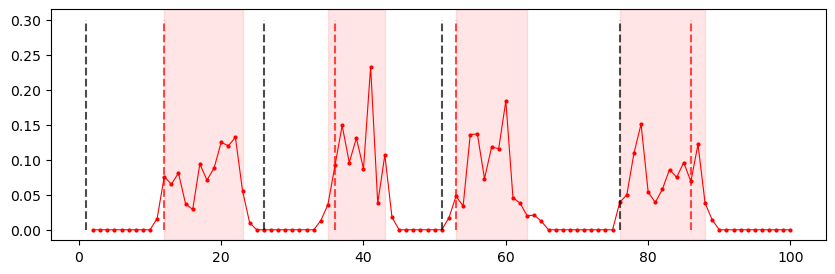

In [45]:
delta_true = np.array([(t in chg_pt or t==1) for t in range(1, T_max+1)]).astype(int)
stage_true = np.cumsum(delta_true)-1
print(f"True change points={np.where(delta_true==1)[0]}")
print(f"Predicted change points={np.where(delta_est==1)[0]}")

prob_delta, HPD = compute_probs(MCMC_chain, delta_est, 0.05)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.arange(2,101), prob_delta[1:], marker='.', markersize=4, color='red', linewidth=0.8)
for i, x in enumerate(np.where(delta_est[1:] == 1)[0]):
    ax.vlines(x+1, ymin=0, ymax=0.3, color='red', linestyle='dashed', alpha=0.7)
    ax.axvspan(HPD[i,0]+1, HPD[i,1]+1, alpha=0.1, color='red')
for x in np.where(delta_true == 1)[0]:
    ax.vlines(x+1, ymin=0, ymax=0.3, color='black', linestyle='dashed', alpha=0.7)

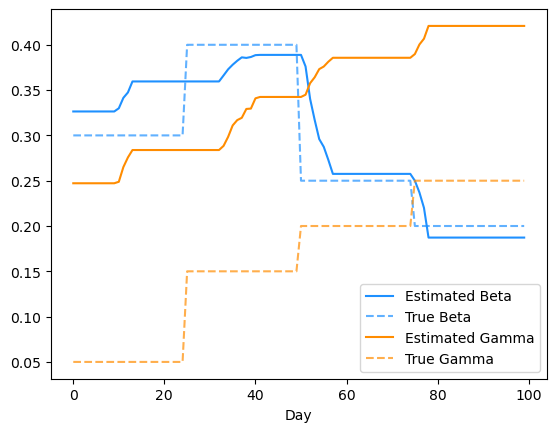

In [16]:
n_sc=3
true_beta  = np.array([[scenarios[i,(chg_pt <= t+1).sum(),0] for t in range(T_max)] for i in range(n_sc)])
true_gamma = np.array([[scenarios[i,(chg_pt <= t+1).sum(),1] for t in range(T_max)] for i in range(n_sc)])

fig, ax = plt.subplots()
ax.plot(beta_est, label="Estimated Beta", color='dodgerblue')
ax.plot(true_beta[0], label="True Beta", color='dodgerblue', linestyle='dashed', alpha=0.7)
ax.plot(gamma_est, label="Estimated Gamma", color='darkorange')
ax.plot(true_gamma[0], label="True Gamma", color='darkorange', linestyle='dashed', alpha=0.7)
ax.set_xlabel("Day")
ax.legend(loc="best")

### Agreement with True Values

In [17]:
def comp_ARI(true, estim, T_max=100):

    comb = np.array(list(itertools.combinations(range(T_max), 2))).T
    true_mask = (true[comb[0]] == true[comb[1]]).astype(int)
    estim_mask = (estim[comb[0]] == estim[comb[1]]).astype(int)

    TP = np.mean(true_mask*estim_mask)
    FP = np.mean((1-true_mask)*estim_mask)
    FN = np.mean(true_mask*(1-estim_mask))
    TN = np.mean((1-true_mask)*(1-estim_mask))
    num = TP+TN-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)
    den = 1-(TP+FP)*(TP+FN)-(TN+FP)*(TN+FN)

    ARI = num/den

    return ARI


In [18]:
def comp_MI(true, estim, T_max=100):
    n_kkprime = np.histogram2d(true, estim, bins=(np.max(true)+1, np.max(estim)+1))[0]
    n_k = np.sum(n_kkprime, axis=1)
    n_kprime = np.sum(n_kkprime, axis=0)
    
    MI = np.sum(n_kkprime/T_max*np.log((n_kkprime+(n_kkprime==0))*T_max/np.outer(n_k, n_kprime)))
    return MI

In [19]:
ARI = comp_ARI(stage_true, stage_est)
MI = comp_MI(stage_true, stage_est)
print(f"ARI = {ARI} out of 1\nMI = {MI} out of 1.386")

ARI = 0.4578276021905955 out of 1
MI = 0.9315037890935388 out of 1.386


# TEST DELTA SAMPLING

In [72]:
n_sample = 100
Delta_hat = MCMC_chain["Delta"][n_sample]
Stage_hat = MCMC_chain["Stage"][n_sample]
K_hat = np.sum(Delta_hat, dtype=int)
beta_hat  = MCMC_chain["beta"][n_sample]
gamma_hat = MCMC_chain["gamma"][n_sample]

In [73]:
p_a = 1/T_max**4
p_b = 2 - p_a
p = 0.01

b_shape = 0.1
b_rate = 0.1
r_shape = 0.1
r_rate = 0.1

gamma_b_shape = gammaFunc(b_shape)
gamma_r_shape = gammaFunc(r_shape)

In [74]:
########## change type
## add–delete–swap - proposal step
# -1 delete
# 0 swap
# +1 add
        
if K_hat==1:
    change_type = 1

elif K_hat==T_max:
    change_type = -1
else:
    np.random.seed(12)
    change_type = np.random.choice([-1, 0, 1])
    
Delta_hat_candidate = Delta_hat.copy()

if change_type != 0:
    
    if change_type == 1:
        possible_change_indices = np.where(Delta_hat[1:] == 0)[0]+1
    elif change_type == -1:
        possible_change_indices = np.where(Delta_hat[1:] == 1)[0]+1
    index_to_change = np.random.choice(possible_change_indices)
    Delta_hat_candidate[index_to_change] = 1 - Delta_hat_candidate[index_to_change]
    Stage_hat_candidate = np.cumsum(Delta_hat_candidate, dtype=int)-1
    if change_type == 1:
        possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 1)[0]+1
        phase_original  = np.array([Stage_hat[index_to_change]])
        phase_candidate = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
    elif change_type == -1:
        possible_change_indices_candidate = np.where(Delta_hat_candidate[1:] == 0)[0]+1
        phase_original  = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
        phase_candidate = np.array([Stage_hat_candidate[index_to_change]])

    logp_original = 0
    logp_candidate = 0
    for i in phase_original:
        L_i_original = np.where(Stage_hat == i)[0]
        logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                       - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                       - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
        logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                       - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                       - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
        logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))
    for i in phase_candidate:
        L_i_candidate = np.where(Stage_hat_candidate == i)[0]
        logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                        - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                        - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
        logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                        - np.log(gamma_r_shape) + r_shape * np.log(r_rate) \
                        - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
        logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))
    logp_candidate += np.log(p_a / p_b) + np.log((3 - 2 * (K_hat == 1)) \
                    * len(possible_change_indices) / (3 - 2 * ((K_hat + 1) == T_max)) / len(possible_change_indices_candidate))
    
    ratio = np.exp(min([0, logp_candidate - logp_original]))
    log_ratio = logp_candidate - logp_original

elif change_type == 0:
    
    possible_change_indices = np.where(np.abs(Delta_hat[1:-1] - Delta_hat[2:]) == 1)[0]+1
    index_to_change = np.random.choice(possible_change_indices, 1)
    Delta_hat_candidate[index_to_change + np.array([0, 1])] = Delta_hat_candidate[index_to_change + np.array([1, 0])]
    Stage_hat_candidate = np.cumsum(Delta_hat_candidate)-1
    possible_change_indices_candidate = np.where(np.abs(Delta_hat_candidate[1:-1] - Delta_hat_candidate[2:]) == 1)[0]+1

    phase = np.array([Stage_hat[index_to_change], Stage_hat_candidate[index_to_change]])
    logp_original = 0
    logp_candidate = 0

    for i in phase:
        L_i_original = np.where(Stage_hat == i)[0]
        logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + b_shape)) \
                       - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                       - (b_shape + len(L_i_original)) * np.log(b_rate + np.sum(beta_hat[L_i_original]))
        logp_original += np.sum(np.log(np.arange(1, len(L_i_original)) - 1 + r_shape)) \
                       - np.log(gamma_b_shape) + r_shape * np.log(r_rate) \
                       - (r_shape + len(L_i_original)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_original])))
        logp_original -= np.sum(np.log(np.arange(1, len(L_i_original))))
        L_i_candidate = np.where(Stage_hat_candidate == i)[0]
        logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + b_shape)) \
                        - np.log(gamma_b_shape) + b_shape * np.log(b_rate) \
                        - (b_shape + len(L_i_candidate)) * np.log(b_rate + np.sum(beta_hat[L_i_candidate]))
        logp_candidate += np.sum(np.log(np.arange(1, len(L_i_candidate)) - 1 + r_shape)) \
                        - np.log(gamma_b_shape) + r_shape * np.log(r_rate) \
                        - (r_shape + len(L_i_candidate)) * np.log(r_rate + np.sum(-np.log(gamma_hat[L_i_candidate])))
        logp_candidate -= np.sum(np.log(np.arange(1, len(L_i_candidate))))

    ratio = np.exp(min([0, logp_candidate - logp_original + np.log(len(possible_change_indices) / len(possible_change_indices_candidate))]))
    log_ratio = logp_candidate - logp_original + np.log(len(possible_change_indices) / len(possible_change_indices_candidate))

cxx = np.random.binomial(1, ratio) 

print("Change type:", change_type)
print("Delta hat:",np.where(Delta_hat==1)[0])
print("Delta_hat candidate:", np.where(Delta_hat_candidate==1)[0])

print("log ratio:", log_ratio)
if cxx ==1:
    print("Accepted")
else:
    print("Denied")

Change type: 1
Delta hat: [ 0 10 35 52 78]
Delta_hat candidate: [ 0  3 10 35 52 78]
log ratio: -19.950865384230696
Denied


In [75]:
K_hat_candidate = np.sum(Delta_hat_candidate, dtype=int)
verbose = True

print("Change type:", change_type)
print("Delta hat:",np.where(Delta_hat==1)[0])
print("Delta_hat candidate:", np.where(Delta_hat_candidate==1)[0])

# Prior log-ratio: pi(d*)/pi(d(g))
log_pi = (K_hat_candidate-K_hat)*np.log(p/(1-p))
    
# Likelihood log-ratio: pi(beta(g), gamma(g)|d*)/pi(beta(g), gamma(g)|d(g))
log1_candidate = 0
log2_candidate = 0
    
for k in range(K_hat_candidate):
    ind_k = np.where(Stage_hat_candidate == k)[0]
    log1_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
    log2_candidate += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
    
log1_original = 0
log2_original = 0
                                 
for k in range(K_hat):
    ind_k = np.where(Stage_hat == k)[0]
    log1_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(beta_hat[ind_k]))
    log2_original += np.log(gammaFunc(0.1+len(ind_k))) - (0.1+len(ind_k))*np.log(0.1+np.sum(-np.log(gamma_hat[ind_k])))
    
log_L = (log1_candidate+log2_candidate) - (log1_original+log2_original)     

# Jump probability log-ratio: J(d(g)|d*)/J(d*|d(g))
JJ = 0
if K_hat == K_hat_candidate:
    JJ = 1 
elif ([K_hat_candidate, K_hat] == [1, 2] or [K_hat_candidate, K_hat] == [T_max, T_max-1]):
    JJ = 3/(T_max-1)
elif ([K_hat_candidate, K_hat] == [2, 1] or [K_hat_candidate, K_hat] == [T_max-1, T_max]):
    JJ = (T_max-1)/3
elif (K_hat_candidate-K_hat) == -1 and K_hat_candidate != 1 and K_hat_candidate != (T_max-1):
    JJ = (K_hat-1)/(T_max - K_hat_candidate)
elif K_hat_candidate - K_hat == 1 and K_hat_candidate != 2 and K_hat_candidate != T_max:
    JJ = (T_max-K_hat)/(K_hat_candidate-1)
log_JJ = np.log(JJ)

# Metropolis-Hastings Ratio
log_mMH = log_L+log_pi+log_JJ
ratio = np.exp(min(0, log_mMH))
if verbose:
    print("pi:", log_pi, np.exp(log_pi))
    print("likelihood:", log_L, np.exp(log_L))
    print("JJ:", log_JJ, JJ)
    print("m_MH:", log_mMH, np.exp(log_mMH))

cxx = np.random.binomial(1, ratio) 
if cxx == 1:
    print("Accepted")
else:
    print("Denied")    

Change type: 1
Delta hat: [ 0 10 35 52 78]
Delta_hat candidate: [ 0  3 10 35 52 78]
pi: -4.59511985013459 0.010101010101010102
likelihood: 0.8443654989110598 2.326501178624959
JJ: 2.9444389791664403 19.0
m_MH: -0.8063153720570897 0.4465002262007497
Denied
